In [ ]:
#|default_exp core

# Cosette's source

## Setup

In [ ]:
#| export
from fastcore import imghdr
from fastcore.utils import *
from fastcore.meta import delegates

import inspect, typing, mimetypes, base64, json, ast
from collections import abc
from random import choices
from string import ascii_letters,digits

from openai import types
from openai import Completion,OpenAI,NOT_GIVEN
from openai.resources import chat
from openai.resources.chat import Completions
from openai.types.chat.chat_completion import ChatCompletion, ChatCompletionMessage
from openai.types.completion_usage import CompletionUsage,CompletionTokensDetails

from toolslm.funccall import *

try: from IPython import display
except: display=None

In [ ]:
#| hide
from nbdev import show_doc

In [ ]:
#| export
empty = inspect.Parameter.empty

In [ ]:
#| exports
models = 'gpt-4o', 'gpt-4-turbo', 'gpt-4', 'gpt-4-32k', 'gpt-3.5-turbo', 'gpt-3.5-turbo-instruct', 'o1-preview', 'o1-mini'

In [ ]:
model = models[0]

For examples, we'll use GPT-4o.

## OpenAI SDK

In [ ]:
cli = OpenAI().chat.completions

In [ ]:
m = {'role': 'user', 'content': "I'm Jeremy"}
r = cli.create(messages=[m], model=model, max_tokens=100)
r

ChatCompletion(id='chatcmpl-A71l5qHZFxzAqnRKiwwmm4vfkTtnC', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='Hi Jeremy! How can I assist you today?', refusal=None, role='assistant', function_call=None, tool_calls=None))], created=1726238419, model='gpt-4o-2024-05-13', object='chat.completion', service_tier=None, system_fingerprint='fp_25624ae3a5', usage=CompletionUsage(completion_tokens=10, prompt_tokens=9, total_tokens=19, completion_tokens_details=CompletionTokensDetails(reasoning_tokens=0)))

### Formatting output

In [ ]:
#| exports
def find_block(r:abc.Mapping, # The message to look in
              ):
    "Find the message in `r`."
    m = nested_idx(r, 'choices', 0)
    if not m: return m
    if hasattr(m, 'message'): return m.message
    return m.delta

In [ ]:
#| exports
def contents(r):
    "Helper to get the contents from response `r`."
    blk = find_block(r)
    if not blk: return r
    if hasattr(blk, 'content'): return getattr(blk,'content')
    return blk

In [ ]:
contents(r)

'Hi Jeremy! How can I assist you today?'

In [ ]:
#| exports
@patch
def _repr_markdown_(self:ChatCompletion):
    det = '\n- '.join(f'{k}: {v}' for k,v in dict(self).items())
    res = contents(self)
    if not res: return f"- {det}"
    return f"""{contents(self)}

<details>

- {det}

</details>"""

In [ ]:
r

Hi Jeremy! How can I assist you today?

<details>

- id: chatcmpl-A71l5qHZFxzAqnRKiwwmm4vfkTtnC
- choices: [Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='Hi Jeremy! How can I assist you today?', refusal=None, role='assistant', function_call=None, tool_calls=None))]
- created: 1726238419
- model: gpt-4o-2024-05-13
- object: chat.completion
- service_tier: None
- system_fingerprint: fp_25624ae3a5
- usage: CompletionUsage(completion_tokens=10, prompt_tokens=9, total_tokens=19, completion_tokens_details=CompletionTokensDetails(reasoning_tokens=0))

</details>

In [ ]:
r.usage

CompletionUsage(completion_tokens=10, prompt_tokens=9, total_tokens=19, completion_tokens_details=CompletionTokensDetails(reasoning_tokens=0))

In [ ]:
#| exports
def usage(inp=0, # Number of prompt tokens
          out=0, # Number of completion tokens
          reas=0 # Number of reasoning tokens
         ):
    "Slightly more concise version of `CompletionUsage`."
    return CompletionUsage(prompt_tokens=inp, completion_tokens=out, completion_tokens_details=CompletionTokensDetails(reasoning_tokens=reas), total_tokens=inp+out+reas)

In [ ]:
usage(5)

CompletionUsage(completion_tokens=0, prompt_tokens=5, total_tokens=5, completion_tokens_details=CompletionTokensDetails(reasoning_tokens=0))

In [ ]:
#| exports
@patch
def __repr__(self:CompletionUsage): return f'In: {self.prompt_tokens}; Out: {self.completion_tokens}; Reasoning: {self.completion_tokens_details.reasoning_tokens}; Total: {self.total_tokens}'

In [ ]:
r.usage

In: 9; Out: 10; Reasoning: 0; Total: 19

In [ ]:
#| exports
@patch
def __add__(self:CompletionUsage, b):
    "Add together each of `input_tokens` and `output_tokens`"
    return usage(self.prompt_tokens+b.prompt_tokens, self.completion_tokens+b.completion_tokens, self.completion_tokens_details.reasoning_tokens+b.completion_tokens_details.reasoning_tokens)

In [ ]:
r.usage+r.usage

In: 18; Out: 20; Reasoning: 0; Total: 38

In [ ]:
#| export
def wrap_latex(text, md=True):
    "Replace OpenAI LaTeX codes with markdown-compatible ones"
    text = re.sub(r"\\\((.*?)\\\)", lambda o: f"${o.group(1)}$", text)
    res = re.sub(r"\\\[(.*?)\\\]", lambda o: f"$${o.group(1)}$$", text, flags=re.DOTALL)
    if md: res = display.Markdown(res)
    return res

### Creating messages

In [ ]:
def mk_msg(content, role='user', **kwargs):
    "Helper to create a `dict` appropriate for a message. `kwargs` are added as key/value pairs to the message"
    if hasattr(content, 'content'): content,role = content.content,content.role
    if isinstance(content, ChatCompletion): return find_block(content)
    return dict(role=role, content=content, **kwargs)

In [ ]:
prompt = "I'm Jeremy"
m = mk_msg(prompt)
r = cli.create(messages=[m], model=model, max_tokens=100)
r

Hello, Jeremy! How can I assist you today?

<details>

- id: chatcmpl-A71l50xqw5gbK8gAmxOUcEN1wi0cV
- choices: [Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='Hello, Jeremy! How can I assist you today?', refusal=None, role='assistant', function_call=None, tool_calls=None))]
- created: 1726238419
- model: gpt-4o-2024-05-13
- object: chat.completion
- service_tier: None
- system_fingerprint: fp_25624ae3a5
- usage: CompletionUsage(completion_tokens=11, prompt_tokens=9, total_tokens=20, completion_tokens_details=CompletionTokensDetails(reasoning_tokens=0))

</details>

In [ ]:
msgs = [mk_msg(prompt), mk_msg(r), mk_msg('I forgot my name. Can you remind me please?')]
msgs

[{'role': 'user', 'content': "I'm Jeremy"},
 ChatCompletionMessage(content='Hello, Jeremy! How can I assist you today?', refusal=None, role='assistant', function_call=None, tool_calls=None),
 {'role': 'user', 'content': 'I forgot my name. Can you remind me please?'}]

In [ ]:
cli.create(messages=msgs, model=model, max_tokens=200)

Sure, you just mentioned your name is Jeremy. Is there anything else you'd like help with?

<details>

- id: chatcmpl-A71l68eyIsBBfJrBUCdwHWw0vTt4b
- choices: [Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content="Sure, you just mentioned your name is Jeremy. Is there anything else you'd like help with?", refusal=None, role='assistant', function_call=None, tool_calls=None))]
- created: 1726238420
- model: gpt-4o-2024-05-13
- object: chat.completion
- service_tier: None
- system_fingerprint: fp_992d1ea92d
- usage: CompletionUsage(completion_tokens=19, prompt_tokens=39, total_tokens=58, completion_tokens_details=CompletionTokensDetails(reasoning_tokens=0))

</details>

## Client

In [ ]:
#| exports
class Client:
    def __init__(self, model, cli=None):
        "Basic LLM messages client."
        self.model,self.use = model,usage(0,0)
        self.c = (cli or OpenAI()).chat.completions

In [ ]:
c = Client(model)
c.use

In: 0; Out: 0; Reasoning: 0; Total: 0

In [ ]:
#| exports
@patch
def _r(self:Client, r:ChatCompletion):
    "Store the result of the message and accrue total usage."
    self.result = r
    if getattr(r,'usage',None): self.use += r.usage
    return r

In [ ]:
c._r(r)
c.use

In: 9; Out: 11; Reasoning: 0; Total: 20

In [ ]:
#| export
def get_stream(r):
    for o in r:
        o = contents(o)
        if o and isinstance(o, str): yield(o)

In [ ]:
#| exports
@patch
@delegates(Completions.create)
def __call__(self:Client,
             msgs:list, # List of messages in the dialog
             sp:str='', # System prompt
             maxtok=4096, # Maximum tokens
             stream:bool=False, # Stream response?
             **kwargs):
    "Make a call to LLM."
    if stream: kwargs['stream_options'] = {"include_usage": True}
    if sp: msgs = [mk_msg(sp, 'system')] + list(msgs)
    r = self.c.create(
        model=self.model, messages=msgs, max_tokens=maxtok, stream=stream, **kwargs)
    if not stream: return self._r(r)
    else: return get_stream(map(self._r, r))

In [ ]:
msgs = [mk_msg('Hi')]

In [ ]:
c(msgs)

Hello! How can I assist you today?

<details>

- id: chatcmpl-A71l7GXsqXVGNOBZBzIEAQa3WerQP
- choices: [Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='Hello! How can I assist you today?', refusal=None, role='assistant', function_call=None, tool_calls=None))]
- created: 1726238421
- model: gpt-4o-2024-05-13
- object: chat.completion
- service_tier: None
- system_fingerprint: fp_25624ae3a5
- usage: CompletionUsage(completion_tokens=9, prompt_tokens=8, total_tokens=17, completion_tokens_details=CompletionTokensDetails(reasoning_tokens=0))

</details>

In [ ]:
c.use

In: 17; Out: 20; Reasoning: 0; Total: 37

In [ ]:
for o in c(msgs, stream=True): print(o, end='')

Hello! How can I assist you today?

In [ ]:
c.use

In: 25; Out: 29; Reasoning: 0; Total: 54

## Tool use

In [ ]:
def sums(
    a:int,  # First thing to sum
    b:int # Second thing to sum
) -> int: # The sum of the inputs
    "Adds a + b."
    print(f"Finding the sum of {a} and {b}")
    return a + b

In [ ]:
#| export
def mk_openai_func(f): return dict(type='function', function=get_schema(f, 'parameters'))

In [ ]:
#| export
def mk_tool_choice(f): return dict(type='function', function={'name':f})

In [ ]:
sysp = "You are a helpful assistant. When using tools, be sure to pass all required parameters, at minimum."

In [ ]:
a,b = 604542,6458932
pr = f"What is {a}+{b}?"
tools=[mk_openai_func(sums)]
tool_choice=mk_tool_choice("sums")

In [ ]:
msgs = [mk_msg(pr)]
r = c(msgs, sp=sysp, tools=tools)
r

- id: chatcmpl-A71l8d2Us97oG6fSyf9eb95yEYRUx
- choices: [Choice(finish_reason='tool_calls', index=0, logprobs=None, message=ChatCompletionMessage(content=None, refusal=None, role='assistant', function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_Rc8BcLzrRmrlz6h8CQFlqQg1', function=Function(arguments='{"a":604542,"b":6458932}', name='sums'), type='function')]))]
- created: 1726238422
- model: gpt-4o-2024-05-13
- object: chat.completion
- service_tier: None
- system_fingerprint: fp_25624ae3a5
- usage: CompletionUsage(completion_tokens=21, prompt_tokens=104, total_tokens=125, completion_tokens_details=CompletionTokensDetails(reasoning_tokens=0))

In [ ]:
m = find_block(r)
m

ChatCompletionMessage(content=None, refusal=None, role='assistant', function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_Rc8BcLzrRmrlz6h8CQFlqQg1', function=Function(arguments='{"a":604542,"b":6458932}', name='sums'), type='function')])

In [ ]:
tc = m.tool_calls
tc

[ChatCompletionMessageToolCall(id='call_Rc8BcLzrRmrlz6h8CQFlqQg1', function=Function(arguments='{"a":604542,"b":6458932}', name='sums'), type='function')]

In [ ]:
func = tc[0].function
func

Function(arguments='{"a":604542,"b":6458932}', name='sums')

In [ ]:
#| exports
def _mk_ns(*funcs:list[callable]) -> dict[str,callable]:
    "Create a `dict` of name to function in `funcs`, to use as a namespace"
    return {f.__name__:f for f in funcs}

In [ ]:
#| exports
def call_func(fc:types.chat.chat_completion_message_tool_call.Function, # Function block from message
              ns:Optional[abc.Mapping]=None, # Namespace to search for tools, defaults to `globals()`
              obj:Optional=None # Object to search for tools
             ):
    "Call the function in the tool response `tr`, using namespace `ns`."
    if ns is None: ns=globals()
    if not isinstance(ns, abc.Mapping): ns = _mk_ns(*ns)
    func = getattr(obj, fc.name, None)
    if not func: func = ns[fc.name]
    return func(**ast.literal_eval(fc.arguments))

In [ ]:
ns = _mk_ns(sums)
res = call_func(func, ns=ns)
res

Finding the sum of 604542 and 6458932


7063474

In [ ]:
#| exports
def mk_toolres(
    r:abc.Mapping, # Tool use request response
    ns:Optional[abc.Mapping]=None, # Namespace to search for tools
    obj:Optional=None # Class to search for tools
    ):
    "Create a `tool_result` message from response `r`."
    r = mk_msg(r)
    tcs = getattr(r, 'tool_calls', [])
    res = [r]
    for tc in (tcs or []):
        func = tc.function
        cts = str(call_func(func, ns=ns, obj=obj))
        res.append(mk_msg(str(cts), 'tool', tool_call_id=tc.id, name=func.name))
    return res

In [ ]:
tr = mk_toolres(r, ns=ns)
tr

Finding the sum of 604542 and 6458932


[ChatCompletionMessage(content=None, refusal=None, role='assistant', function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_Rc8BcLzrRmrlz6h8CQFlqQg1', function=Function(arguments='{"a":604542,"b":6458932}', name='sums'), type='function')]),
 {'role': 'tool',
  'content': '7063474',
  'tool_call_id': 'call_Rc8BcLzrRmrlz6h8CQFlqQg1',
  'name': 'sums'}]

In [ ]:
msgs += tr

In [ ]:
res = c(msgs, sp=sysp, tools=tools)
res

The sum of 604542 and 6458932 is 7,063,474.

<details>

- id: chatcmpl-A71l94yXlBvkG7rQjcGpLU8mPjwQV
- choices: [Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='The sum of 604542 and 6458932 is 7,063,474.', refusal=None, role='assistant', function_call=None, tool_calls=None))]
- created: 1726238423
- model: gpt-4o-2024-05-13
- object: chat.completion
- service_tier: None
- system_fingerprint: fp_25624ae3a5
- usage: CompletionUsage(completion_tokens=20, prompt_tokens=136, total_tokens=156, completion_tokens_details=CompletionTokensDetails(reasoning_tokens=0))

</details>

In [ ]:
class Dummy:
    def sums(
        self,
        a:int,  # First thing to sum
        b:int=1 # Second thing to sum
    ) -> int: # The sum of the inputs
        "Adds a + b."
        print(f"Finding the sum of {a} and {b}")
        return a + b

In [ ]:
tools = [mk_openai_func(Dummy.sums)]

o = Dummy()
msgs = mk_toolres("I'm Jeremy")
r = c(msgs, sp=sysp, tools=tools)
msgs += mk_toolres(r, obj=o)
res = c(msgs, sp=sysp, tools=tools)
res

Hi Jeremy! How can I assist you today?

<details>

- id: chatcmpl-A71lA5oPH5j5IbyNWTFlLcL1KBWDM
- choices: [Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='Hi Jeremy! How can I assist you today?', refusal=None, role='assistant', function_call=None, tool_calls=None))]
- created: 1726238424
- model: gpt-4o-2024-05-13
- object: chat.completion
- service_tier: None
- system_fingerprint: fp_25624ae3a5
- usage: CompletionUsage(completion_tokens=11, prompt_tokens=116, total_tokens=127, completion_tokens_details=CompletionTokensDetails(reasoning_tokens=0))

</details>

In [ ]:
msgs

[{'role': 'user', 'content': "I'm Jeremy"},
 ChatCompletionMessage(content='Hi Jeremy! How can I assist you today?', refusal=None, role='assistant', function_call=None, tool_calls=None)]

In [ ]:
tools = [mk_openai_func(Dummy.sums)]

o = Dummy()
msgs = mk_toolres(pr)
r = c(msgs, sp=sysp, tools=tools)
msgs += mk_toolres(r, obj=o)
res = c(msgs, sp=sysp, tools=tools)
res

Finding the sum of 604542 and 6458932


The sum of 604542 and 6458932 is 7063474.

<details>

- id: chatcmpl-A71lBLJl1oP4MZL9sahPyChxA3r5n
- choices: [Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='The sum of 604542 and 6458932 is 7063474.', refusal=None, role='assistant', function_call=None, tool_calls=None))]
- created: 1726238425
- model: gpt-4o-2024-05-13
- object: chat.completion
- service_tier: None
- system_fingerprint: fp_992d1ea92d
- usage: CompletionUsage(completion_tokens=18, prompt_tokens=142, total_tokens=160, completion_tokens_details=CompletionTokensDetails(reasoning_tokens=0))

</details>

In [ ]:
#| exports

def _mock_id(): return 'call_' + ''.join(choices(ascii_letters+digits, k=24))

def mk_tooluse(name:str, # The name of the called function
                 res,  # The result of calling the function
                 **kwargs): # The arguments to the function
    ""
    id = _mock_id()
    func = dict(arguments=json.dumps(kwargs), name=name)
    tc = dict(id=id, function=func, type='function')
    req = dict(content=None, role='assistant', tool_calls=[tc])
    resp = mk_msg('' if res is None else str(res), 'tool', tool_call_id=id, name=name)
    return [req,resp]

This function mocks the messages needed to implement tool use, for situations where you want to insert tool use messages into a dialog without actually calling into the model.

In [ ]:
tu = mk_tooluse(name='sums', res=7063474, a=604542, b=6458932)
r = c([mk_msg(pr)]+tu, tools=tools)
r

The sum of 604542 and 6458932 is 7,063,474.

<details>

- id: chatcmpl-A71lCFYciuaeSa8SK9JdO97eJAaKT
- choices: [Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='The sum of 604542 and 6458932 is 7,063,474.', refusal=None, role='assistant', function_call=None, tool_calls=None))]
- created: 1726238426
- model: gpt-4o-2024-05-13
- object: chat.completion
- service_tier: None
- system_fingerprint: fp_25624ae3a5
- usage: CompletionUsage(completion_tokens=20, prompt_tokens=121, total_tokens=141, completion_tokens_details=CompletionTokensDetails(reasoning_tokens=0))

</details>

## Chat

In [ ]:
#| exports
class Chat:
    def __init__(self,
                 model:Optional[str]=None, # Model to use (leave empty if passing `cli`)
                 cli:Optional[Client]=None, # Client to use (leave empty if passing `model`)
                 sp='', # Optional system prompt
                 tools:Optional[list]=None,  # List of tools to make available
                 tool_choice:Optional[str]=None): # Forced tool choice
        "OpenAI chat client."
        assert model or cli
        self.c = (cli or Client(model))
        self.h,self.sp,self.tools,self.tool_choice = [],sp,tools,tool_choice
    
    @property
    def use(self): return self.c.use

In [ ]:
sp = "Never mention what tools you use."
chat = Chat(model, sp=sp)
chat.c.use, chat.h

(In: 0; Out: 0; Reasoning: 0; Total: 0, [])

In [ ]:
#| exports
@patch
@delegates(Completions.create)
def __call__(self:Chat,
             pr=None,  # Prompt / message
             stream:bool=False, # Stream response?
             **kwargs):
    "Add prompt `pr` to dialog and get a response"
    if isinstance(pr,str): pr = pr.strip()
    if pr: self.h.append(mk_msg(pr))
    if self.tools: kwargs['tools'] = [mk_openai_func(o) for o in self.tools]
    if self.tool_choice: kwargs['tool_choice'] = mk_tool_choice(tool_choice)
    res = self.c(self.h, sp=self.sp, stream=stream, **kwargs)
    self.h += mk_toolres(res, ns=self.tools, obj=self)
    return res

In [ ]:
chat("I'm Jeremy")
chat("What's my name?")

Your name is Jeremy! How can I help you today?

<details>

- id: chatcmpl-A71lDPoGYQqYxHg4aop4LAq7XyZiF
- choices: [Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='Your name is Jeremy! How can I help you today?', refusal=None, role='assistant', function_call=None, tool_calls=None))]
- created: 1726238427
- model: gpt-4o-2024-05-13
- object: chat.completion
- service_tier: None
- system_fingerprint: fp_25624ae3a5
- usage: CompletionUsage(completion_tokens=12, prompt_tokens=46, total_tokens=58, completion_tokens_details=CompletionTokensDetails(reasoning_tokens=0))

</details>

In [ ]:
chat = Chat(model, sp=sp)
for o in chat("I'm Jeremy", stream=True):
    o = contents(o)
    if o and isinstance(o, str): print(o, end='')

Nice to meet you, Jeremy! How can I assist you today?

### Chat tool use

In [ ]:
pr = f"What is {a}+{b}?"
pr

'What is 604542+6458932?'

In [ ]:
chat = Chat(model, sp=sp, tools=[sums])
r = chat(pr)
r

Finding the sum of 604542 and 6458932


- id: chatcmpl-A71lEDiPDknFsM78lkWrYxJL3IoDK
- choices: [Choice(finish_reason='tool_calls', index=0, logprobs=None, message=ChatCompletionMessage(content=None, refusal=None, role='assistant', function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_M3cmrOwBBB3kP4LNu8nEQbT6', function=Function(arguments='{"a":604542,"b":6458932}', name='sums'), type='function')]))]
- created: 1726238428
- model: gpt-4o-2024-05-13
- object: chat.completion
- service_tier: None
- system_fingerprint: fp_25624ae3a5
- usage: CompletionUsage(completion_tokens=21, prompt_tokens=90, total_tokens=111, completion_tokens_details=CompletionTokensDetails(reasoning_tokens=0))

In [ ]:
chat()

The result of 604542 + 6458932 is 7,063,474.

<details>

- id: chatcmpl-A71lFZXlVy7osw3bkakeKyf7ciACg
- choices: [Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='The result of 604542 + 6458932 is 7,063,474.', refusal=None, role='assistant', function_call=None, tool_calls=None))]
- created: 1726238429
- model: gpt-4o-2024-05-13
- object: chat.completion
- service_tier: None
- system_fingerprint: fp_25624ae3a5
- usage: CompletionUsage(completion_tokens=20, prompt_tokens=122, total_tokens=142, completion_tokens_details=CompletionTokensDetails(reasoning_tokens=0))

</details>

## Images

As everyone knows, when testing image APIs you have to use a cute puppy.

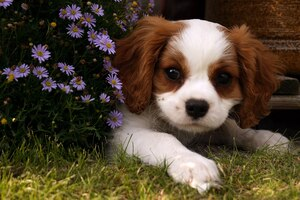

In [ ]:
# Image is Cute_dog.jpg from Wikimedia
fn = Path('samples/puppy.jpg')
display.Image(filename=fn, width=200)

In [ ]:
img = fn.read_bytes()

```js
{
  "type": "image_url",
  "image_url": {
    "url": f"data:image/jpeg;base64,{base64_image}"
  }
}
```

In [ ]:
#| exports
def img_msg(data:bytes)->dict:
    "Convert image `data` into an encoded `dict`"
    img = base64.b64encode(data).decode("utf-8")
    mtype = mimetypes.types_map['.'+imghdr.what(None, h=data)]
    r = {'url': f"data:{mtype};base64,{img}"}
    return {'type': "image_url", "image_url": r}

In [ ]:
#| exports
def text_msg(s:str)->dict:
    "Convert `s` to a text message"
    return {"type": "text", "text": s}

In [ ]:
q = "In brief, what color flowers are in this image?"
msg = mk_msg([img_msg(img), text_msg(q)])

In [ ]:
c([msg])

The flowers in the image are purple.

<details>

- id: chatcmpl-A71lHeBEjmSr3ySv7EtavZiRvYw3D
- choices: [Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='The flowers in the image are purple.', refusal=None, role='assistant', function_call=None, tool_calls=None))]
- created: 1726238431
- model: gpt-4o-2024-05-13
- object: chat.completion
- service_tier: None
- system_fingerprint: fp_992d1ea92d
- usage: CompletionUsage(completion_tokens=8, prompt_tokens=273, total_tokens=281, completion_tokens_details=CompletionTokensDetails(reasoning_tokens=0))

</details>

In [ ]:
#| exports
def _mk_content(src):
    "Create appropriate content data structure based on type of content"
    if isinstance(src,str): return text_msg(src)
    if isinstance(src,bytes): return img_msg(src)
    return src

There's not need to manually choose the type of message, since we figure that out from the data of the source data.

In [ ]:
_mk_content('Hi')

{'type': 'text', 'text': 'Hi'}

In [ ]:
#| export
def mk_msg(content, # A string, list, or dict containing the contents of the message
           role='user', # Must be 'user' or 'assistant'
           **kwargs):
    "Helper to create a `dict` appropriate for a message. `kwargs` are added as key/value pairs to the message"
    if hasattr(content, 'content'): content,role = content.content,content.role
    if isinstance(content, ChatCompletion): return find_block(content)
    if content is not None and not isinstance(content, list): content=[content]
    content = [_mk_content(o) for o in content] if content else ''
    return dict(role=role, content=content, **kwargs)

In [ ]:
c([mk_msg([img, q])])

The flowers in the image are purple.

<details>

- id: chatcmpl-A71lIXXTpNLOt4hji2JRSvHTcRwCu
- choices: [Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='The flowers in the image are purple.', refusal=None, role='assistant', function_call=None, tool_calls=None))]
- created: 1726238432
- model: gpt-4o-2024-05-13
- object: chat.completion
- service_tier: None
- system_fingerprint: fp_992d1ea92d
- usage: CompletionUsage(completion_tokens=8, prompt_tokens=273, total_tokens=281, completion_tokens_details=CompletionTokensDetails(reasoning_tokens=0))

</details>

## Export -

In [ ]:
#|hide
#|eval: false
from nbdev.doclinks import nbdev_export
nbdev_export()